In [49]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from Functions import Metrics, DescrStat

In [50]:
df = pd.read_csv('Hotel_Reservations_clean.csv')
df.head(3)

,Booking_ID,num_adults,num_children,weekend_nights,week_nights,total_nights,meal_plan,car_parking,room_type,lead_time,...,num_prev_not_canceled,avg_price_room,num_sp_requests,booking_status,total_guests,meal_plan_cod,room_type_cod,mkt_segment_cod,arrival_season_cod,booking_status_cod
0,INN00001,2,0,1,2,3,Meal Plan 1,0,Room_Type 1,224,...,0,65.00,0,No cancelada,2,1,1,3,3,0
1,INN00002,2,0,2,3,5,Not Selected,0,Room_Type 1,5,...,0,106.68,1,No cancelada,2,0,1,4,1,0
2,INN00003,1,0,2,1,3,Meal Plan 1,0,Room_Type 1,1,...,0,60.00,0,Cancelada,1,1,1,4,1,1


## Pre-Procesamiento

### Imputacion de valores outliers de la variable ***avg_price_room***

Esta variable describe el precio promedio en euros de la habitacion rentada. El metodo ***describe()*** en la celda posterior, muestra el valor ***cero*** como minimo de la variable, lo cual no tiene sentido para este caso. Tambien se observa un valor maximo que se despega bastante del 3er cuartil lo cual puede que sea un indicio de la presencia de valores atipicos. En esta seccion se evaluaran los casos mencionados y la forma en que estos seran tratados.

In [51]:
#INFORMACION DE LA VARIABLE
df.avg_price_room.describe()

count    36133.000000
mean       103.509164
std         35.062636
min          0.000000
25%         80.390000
50%         99.480000
75%        120.120000
max        540.000000
Name: avg_price_room, dtype: float64

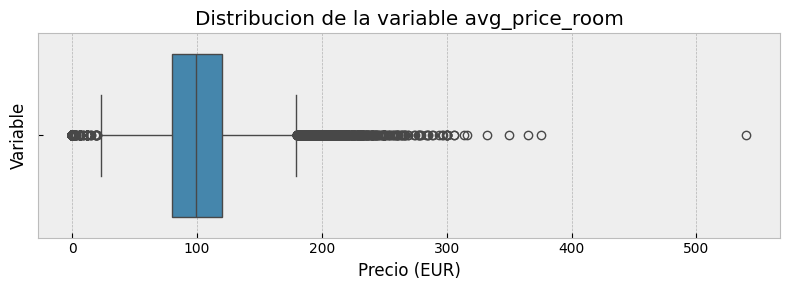

In [52]:
#BOXPLOT PARA IDENTIFICAR OUTLIERS
plt.figure(figsize=(8,3))
mpl.style.use('bmh')
sns.boxplot(x=df.avg_price_room)
plt.title(f'Distribucion de la variable avg_price_room')
plt.xlabel('Precio (EUR)')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()
mpl.style.use('default')

Para la deteccion de valores outliers se utilizara el algoritmo ***MCD (Minimun Covariance Determinant)*** de la librería ***scikit-learn***. Luego se entrenara un modelo de ***ML*** a fines de predecir los precios correctos para aquellos valores que fueron clasificados como outliers por el ***MCD***.

In [53]:
#SE IMPORTA MODELO DETECCION DE OUTLIERS
from sklearn.covariance import EllipticEnvelope

#SE RESETEAN INDICES PARA EVITAR INCONCISTENCIAS
df = df.reset_index()

#SE INSTANCIA EL MODELO Y SE REALIZA PREDICCION
cov_det = EllipticEnvelope(contamination=0.05)
predict = cov_det.fit_predict(df.avg_price_room.values.reshape(-1,1))

#SE CREA DATAFRAME DE REFERENCIA PARA PRECIOS OUTLIERS
predict = pd.concat([df.avg_price_room,
                     pd.Series(predict.flatten(), name='is_outlier')],
                     axis=1)

#CONTEO DE OUTLIERS
print(f'Cantidad de outliers encontrados: {predict.loc[predict.is_outlier == -1].shape[0]}')

Cantidad de outliers encontrados: 1784


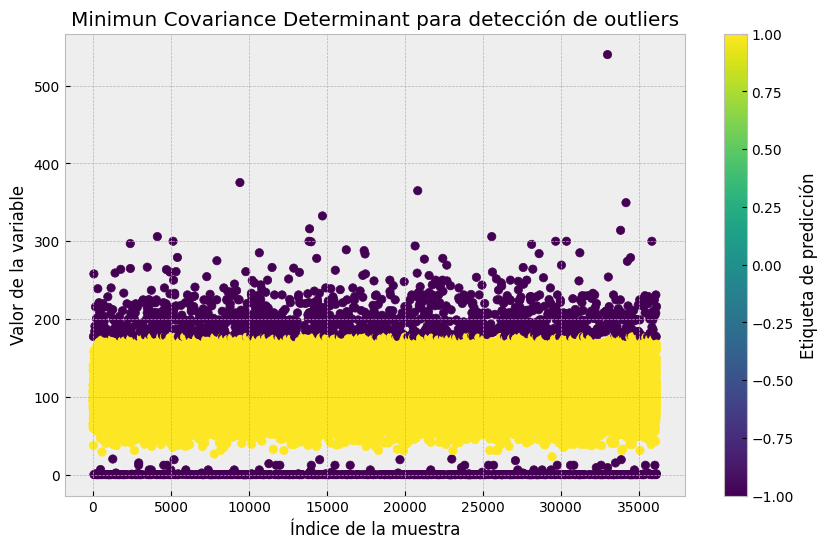

In [54]:
#REPRESENTACION GRAFICA DE OUTLIERS
mpl.style.use('bmh')
plt.figure(figsize=(10,6))
plt.scatter(predict.index, predict.avg_price_room, c=predict.is_outlier, cmap='viridis')
plt.xlabel('Índice de la muestra')
plt.ylabel('Valor de la variable')
plt.title('Minimun Covariance Determinant para detección de outliers')
plt.colorbar(label='Etiqueta de predicción')
plt.show()
mpl.style.use('bmh')

#### Feature Engineering para entrenar modelo de prediccion de precios outliers

In [55]:
#SE CREA DATAFRAME COMPLEMENTARIO PARA TESTEAR MODELO
_df = pd.concat([df, predict.is_outlier], axis=1)

#ENCODING DE VARIABLES CUALITATIVAS QUE CORRELACIONAN CON LA VARIABLE A PREDECIR
var_dummy = pd.get_dummies(_df[['mkt_segment','room_type']], dtype=int)

In [56]:
#LISTA DE VARIABLES DE "_df" IMPLICADAS EN LA SELECCION 
vars = [ 'booking_status_cod','lead_time','total_guests', 'arrival_year',
         'num_sp_requests', 'is_outlier','avg_price_room']

#UNION DE TODAS LAS VARIABLES IMPLICADAS EN LA SELECCION
_df = pd.concat([var_dummy, _df[vars]], axis=1)

#LISTA DE VARIABLES PREDICTIVAS
vars = list(_df.columns)[:-2]

#SELECCION DE VARIABLES PREDICTIVAS PARA ENTRENAMIENTO
x = _df.loc[_df.is_outlier == 1, vars]
y = _df.loc[_df.is_outlier == 1, 'avg_price_room']

#OBSERVACIONES A PREDECIR
x_outlier = _df.loc[_df.is_outlier == -1, vars]

#### Entrenamiento de modelo ***Random Forest Regressor*** para imputar outliers

En esta caso se utilizara el algoritmo ***Random Forest Regressor*** ya que si bien no se muestra por una cuestion de agilidad, entre varios algoritmos este ha dado del mejor resultado. 

In [57]:
#IMPORTACION DE LIBRERIAS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [58]:
#SELECCION DE DATOS PARA ENTRENAMIENTO Y TEST
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

#INSTANCIA, ENTRENAMIENTO Y PREDICCION
model = RandomForestRegressor(max_depth=12, max_features=0.5, n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [59]:
#METRICAS DE REGRESION
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")

Mean Squared Error (MSE): 378.4133710739239
Root Mean Squared Error (RMSE): 19.45284994734509
R^2 Score: 0.48299774576418997


#### Imputacion y analisis

In [60]:
#PREDICCION DE PRECIOS
y_pred = model.predict(x_outlier)

#SE AGREGA AL DATAFRAME PRINCIPAL
_df.loc[_df.is_outlier == -1, 'avg_price_room'] = y_pred

#SE REEMPLAZAN LOS VALORES DEL DATAFRAME PRINCIPAL
df.avg_price_room = _df.avg_price_room

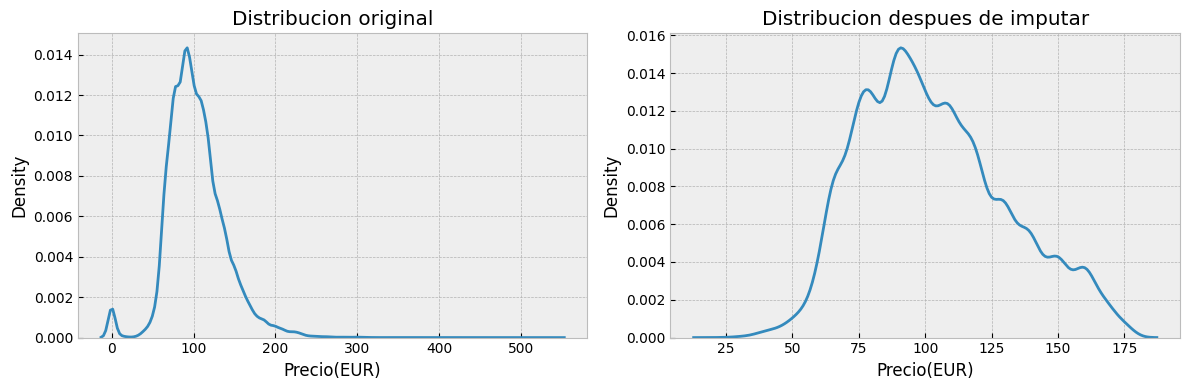

In [61]:
#GRAFICO DE COMPARACION DE DISTRIBUCIONES
plt.style.use("bmh")    
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

#GRAFICO 1
sns.kdeplot(x=predict.avg_price_room, ax=ax[0])
ax[0].set_title('Distribucion original')
ax[0].set_xlabel('Precio(EUR)')
 
#GRAFICO 2
sns.kdeplot(data=df.avg_price_room, ax=ax[1])
ax[1].set_xlabel('Precio(EUR)')
ax[1].set_title(f'Distribucion despues de imputar')

#PLOTEO
plt.tight_layout()
plt.show()
plt.style.use("default")

In [62]:
#INFO VARIABLE ANTES DE IMPUTAR
print('-----Antes de imputar-----')
DescrStat.get_var_data(predict.avg_price_room)

-----Antes de imputar-----


median        99.4800
mean         103.5092
mode          65.0000
std           35.0626
variance    1229.3884
skew           0.6760
kurtosys       3.1577
dtype: float64

In [63]:
#INFO VARIABLE DESPUES DE IMPUTAR
print('-----Despues de imputar-----')
DescrStat.get_var_data(df.avg_price_room)

-----Despues de imputar-----


median       99.9000
mean        103.0559
mode         65.0000
std          27.7816
variance    771.8190
skew          0.4387
kurtosys     -0.4077
dtype: float64

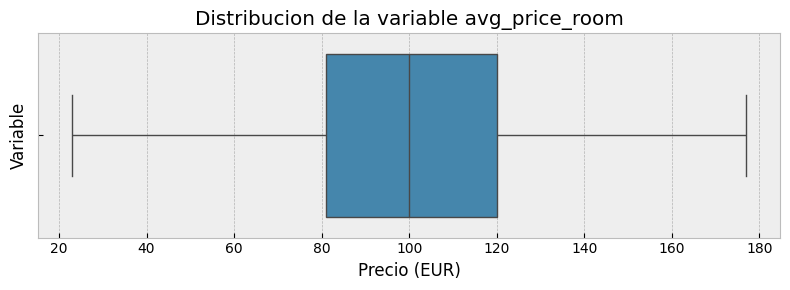

In [64]:
#BOXPLOT PARA IDENTIFICAR OUTLIERS
plt.figure(figsize=(8,3))
mpl.style.use('bmh')
sns.boxplot(x=df.avg_price_room)
plt.title(f'Distribucion de la variable avg_price_room')
plt.xlabel('Precio (EUR)')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()
mpl.style.use('default')

In [65]:
#SE LIBERAN RECURSOS
del _df
del predict
del cov_det
del model
del x, y
del X_train, X_test, y_train, y_test
del y_pred

#INFO
df.avg_price_room.describe()

count    36133.00000
mean       103.05591
std         27.78163
min         23.00000
25%         81.00000
50%         99.90000
75%        120.00000
max        177.00000
Name: avg_price_room, dtype: float64

### Codificacion de variables cualitativas

Basado en el proceso de **Exploratory Data Analysis** se selecciona la variable **mkt_segment** para ser codificada y utilizada como variable predictiva dada su correlatividad con la variable target.

In [66]:
var_dummy = pd.get_dummies(df.mkt_segment, dtype=int)
var_dummy.head(3)

,Aviation,Complementary,Corporate,Offline,Online
0,0,0,0,1,0
1,0,0,0,0,1
2,0,0,0,0,1


## Modelado

En esta seccion se aborda el proceso de preparacion, seleccion, entrenamiento y validacion de los algoritmos de machine learning que intentaran resolver la problematica planteada a lo largo del documento.<br>
En primer lugar se realizaran todas las transformaciones necesarias en las variables para poder obtener su mayor poder predictivo, luego se seleccionaran todas aquellas variables que se consideren explicativas para predecir la variable objetivo.<br>

Luego se procede a entrenar, testear y validar los siguientes modelos:
- KNN
- Tree Decision
- Random Forest
- XG-Boost

### Feature engineering

En este caso las variables que representan a la fecha de arribo se dividen en tres, estas variables son ***arrival_year***, ***arrival_month*** y ***arrival_day*** las cuales describen el año, mes y dia del arribo respectivamente. En el ***Dataset*** sobre el cual se basa este proyecto, la variable que representa al año solo adquiere dos valores, 2017 y 2018, propio de los datos historicos proporcionados por el cliente. Y como el modelo sera utilizado en años posteriores a los disponibles para el entrenamiento, he decidido omitir esta variable para predecir la variable de interes, ya que esto podria ponderar en las metricas de manera positiva, pero al momento de desplegar el modelo los valores de los años que reciba en etapa de produccion serian diferentes y esto podria producir un rendimiento mas bajo de lo esperado.<br>
En base a la decision explicada anteriormente, se toman las variables representativas al mes y dia a fines de reducir su dimensionalidad con el algoritmo ***PCA*** a una sola variable y comparar como afecta al modelo en relacion a metricas de anteriores entregas.

In [67]:
#SE ESTANDARIZAN VARIABLES (µ=0; σ=1)
scaler = StandardScaler()
date_vars = scaler.fit_transform(df[['arrival_day', 'arrival_month']])

#REDUCCION DE DIMENSIONALIDAD
pca = PCA(n_components=1)
reduce_vars = pca.fit_transform(date_vars)
reduce_vars = pd.Series(reduce_vars.flatten(), name='reduce_var')

#RESULTADO
print(f'Varianza explicada por la variable reducida: {pca.explained_variance_ratio_}')

Varianza explicada por la variable reducida: [0.52167988]


Se realiza una transformacion sobre las variables **lead_time** y **avg_price_room.** He decidido estandarizar ambas variables **(µ=0; σ=1)** ya que ambas tienen una escala de amplitud considerablemente mayor al resto.

In [68]:
#SE ESTANDARIZAN VARIABLES (µ=0; σ=1)
std_vars = pd.DataFrame(StandardScaler().fit_transform(df[['lead_time', 'avg_price_room']]),
                        columns=['lead_time', 'avg_price_room'])

#RESULTADO
std_vars.head(3)

,lead_time,avg_price_room
0,1.615007,-1.369842
1,-0.932939,0.130451
2,-0.979477,-1.549819


Ya realizadas las transformaciones necesarias se procede a seleccionar las variables que seran utilizadas para predecir la variable objetivo.

In [69]:
#SELECCION DE VARIABLES PARA EL ENTRENAMIENTO
vars = ['num_sp_requests','car_parking','num_children',
        'weekend_nights', 'week_nights','room_type_cod']

x = pd.concat([df[vars], std_vars, reduce_vars,var_dummy], axis=1)

y = df.booking_status_cod

In [70]:
#SPLIT DE LOS DATOS PARA ENTRENAR Y VALIDAR
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y, random_state=42)

### Etrenamiento, metricas y validacion de modelos

#### KNN

In [71]:
#IMPORTACION DE LIBRERIA
from sklearn.neighbors import KNeighborsClassifier

#INSTANCIA Y ENTRENAMIENTO DEL MODELO
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

#PREDICCION
y_pred = model.predict(X_test)

#LISTA PARA ALOJAR METRICAS
metrics_list = []

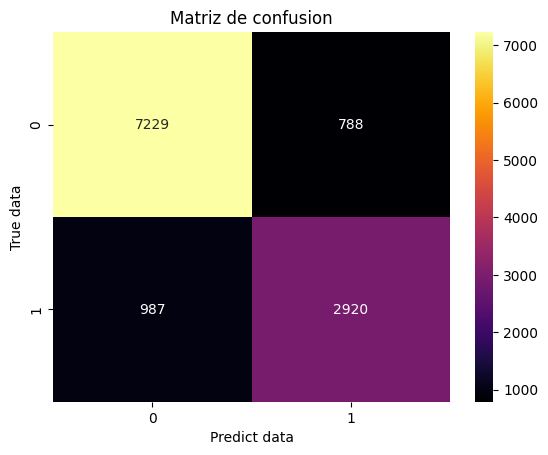

In [72]:
#GRAFICO DE MATRIZ DE CONFUSION
Metrics().plot_matrix_confusion(y_test, y_pred)

In [73]:
#REPORTE DE METRICAS
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      8017
           1       0.79      0.75      0.77      3907

    accuracy                           0.85     11924
   macro avg       0.83      0.82      0.83     11924
weighted avg       0.85      0.85      0.85     11924



In [74]:
#SCORE CURVA ROC
y_prob = model.predict_proba(X_test)[:,1]
print(f'Score curva ROC: {roc_auc_score(y_test, y_prob).round(4)}')

Score curva ROC: 0.8969


In [75]:
#SE AGREGA METRICA A LA LISTA
metrics_list.append(Metrics().get_metrics('KNN', y_test, y_pred, y_prob))

#### Tree decision

In [76]:
#IMPORTACION DE LIBRERIA
from sklearn.tree import DecisionTreeClassifier

#INSTANCIA Y ENTRENAMIENTO DEL MODELO
model = DecisionTreeClassifier()

model.fit(X_train, y_train)

#PREDICCION
y_pred = model.predict(X_test)

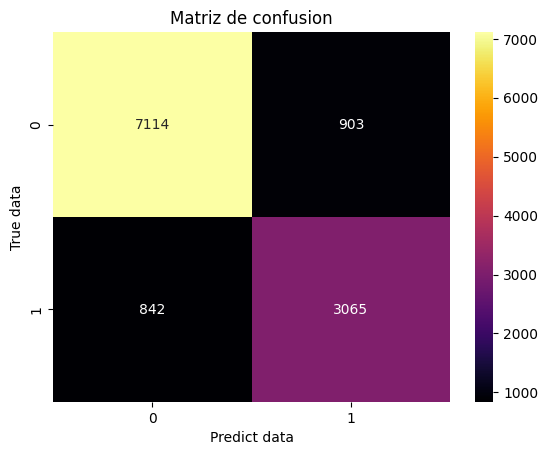

In [77]:
#GRAFICO DE MATRIZ DE CONFUSION
Metrics().plot_matrix_confusion(y_test, y_pred)

In [78]:
#REPORTE DE METRICAS
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      8017
           1       0.77      0.78      0.78      3907

    accuracy                           0.85     11924
   macro avg       0.83      0.84      0.83     11924
weighted avg       0.85      0.85      0.85     11924



In [79]:
#SCORE CURVA ROC
y_prob = model.predict_proba(X_test)[:,1]
print(f'Score curva ROC: {roc_auc_score(y_test, y_prob).round(4)}')

Score curva ROC: 0.8376


In [80]:
#SE AGREGA METRICA A LA LISTA
metrics_list.append(Metrics().get_metrics('TREE', y_test, y_pred, y_prob))

#### Random Forest

In [81]:
#IMPORTACION DE LIBRERIA
from sklearn.ensemble import RandomForestClassifier

#INSTANCIA Y ENTRENAMIENTO DEL MODELO
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

#PREDICCION
y_pred = model.predict(X_test)

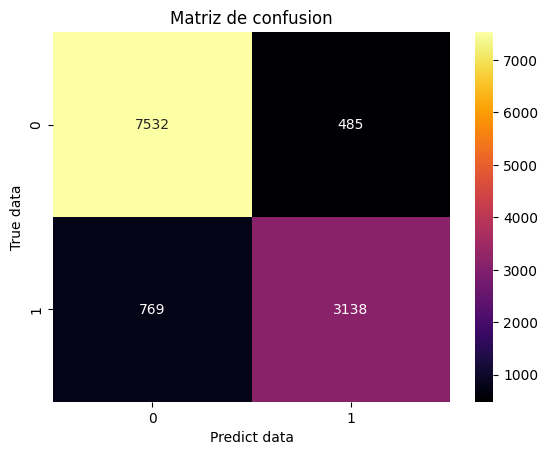

In [82]:
#GRAFICO DE MATRIZ DE CONFUSION
Metrics().plot_matrix_confusion(y_test, y_pred)

In [83]:
#REPORTE DE METRICAS
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      8017
           1       0.87      0.80      0.83      3907

    accuracy                           0.89     11924
   macro avg       0.89      0.87      0.88     11924
weighted avg       0.89      0.89      0.89     11924



In [84]:
#SCORE CURVA ROC
y_prob = model.predict_proba(X_test)[:,1]
print(f'Score curva ROC: {roc_auc_score(y_test, y_prob).round(4)}')

Score curva ROC: 0.9488


In [85]:
#SE AGREGA METRICA A LA LISTA
metrics_list.append(Metrics().get_metrics('RF', y_test, y_pred, y_prob))

#### XG-Boosting

In [86]:
#IMPORTACION DE MODELOS
from xgboost import XGBClassifier

model = XGBClassifier()

#ENTRENAMIENTO
model.fit(X_train,y_train)

#PREDICCION
y_pred = model.predict(X_test)

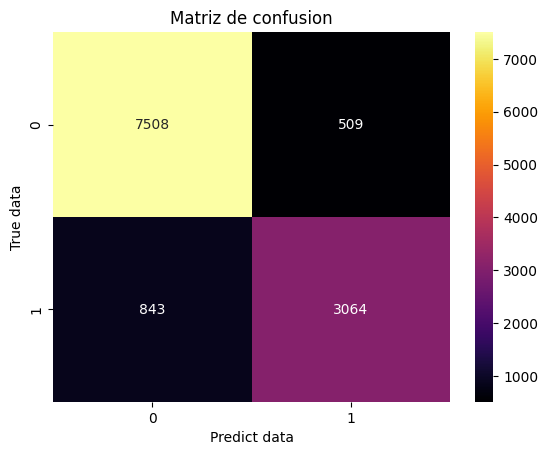

In [87]:
#GRAFICO MATRIZ DE CONFUSION
Metrics().plot_matrix_confusion(y_test, y_pred)

In [88]:
#REPORTE DE METRICAS
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      8017
           1       0.86      0.78      0.82      3907

    accuracy                           0.89     11924
   macro avg       0.88      0.86      0.87     11924
weighted avg       0.89      0.89      0.89     11924



In [89]:
#SCORE CURVA ROC
y_prob = model.predict_proba(X_test)[:,1]
print(f'Score curva ROC: {roc_auc_score(y_test, y_prob):.4f}')

Score curva ROC: 0.9421


In [90]:
#SE AGREGA METRICA A LA LISTA
metrics_list.append(Metrics().get_metrics('XGB', y_test, y_pred, y_prob))

#### Analisis de metricas, mejora de modelo y validacion cruzada

En esta estapa se visualizan las metricas obtenidas en los modelos entrenados anteriormente y se seleccionara aquel con mejores resultados a fines de mejorar dicho modelo y obtener los mejores resultados posibles. 

In [91]:
#VISUALIZACION DE METRICAS
pd.DataFrame(metrics_list)

,model,accuracy,roc_score,precision_0,precision_1,recall_0,recall_1,f1_score_0,f1_score_1
0,KNN,0.8511,0.8969,0.8799,0.7875,0.9017,0.7474,0.8907,0.7669
1,TREE,0.8537,0.8376,0.8942,0.7724,0.8874,0.7845,0.8908,0.7784
2,RF,0.8948,0.9488,0.9074,0.8661,0.9395,0.8032,0.9232,0.8335
3,XGB,0.8866,0.9421,0.8991,0.8575,0.9365,0.7842,0.9174,0.8193


Como se ve anteriormente en la tabla, las mejores metricas se han obtenido mediante el algoritmo ***Random Forest Classifier***. Posteriormente se intentara mejorar este modelo y se lo sometera a validacion cruzada para evaluar su precision expuesto a diferentes sets de entrenamiento y test.

In [92]:
#BUSQUEDA DE PARAMETROS
grid_param = param_grid = {
    'criterion' : ['entropy','gini'],
    'n_estimators': [200, 300],
    'max_depth': [10, 18, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False],
    'random_state': [42]
}

In [93]:
#INSTANCIA Y ENTRENAMIENTO DEL MODELO
model = GridSearchCV(estimator=RandomForestClassifier(),
                     param_grid=param_grid,
                     cv=3, n_jobs=-1,
                     scoring='accuracy')

model.fit(X_train, y_train)

#PREDICCION
y_pred = model.predict(X_test)

In [94]:
#MEJORES PARAMETROS
model.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 300,
 'random_state': 42}

In [96]:
#COMPARACION DE METRICAS ENTRE RF Y RF CON TUNNING DE HYPERPARAMETROS
y_prob = model.predict_proba(X_test)[:,1]
comparison = [metrics_list[2], Metrics().get_metrics('RF_GridSearch',y_test, y_pred, y_prob)]
pd.DataFrame(comparison)

,model,accuracy,roc_score,precision_0,precision_1,recall_0,recall_1,f1_score_0,f1_score_1
0,RF,0.8948,0.9488,0.9074,0.8661,0.9395,0.8032,0.9232,0.8335
1,RF_GridSearch,0.8978,0.9509,0.9086,0.8727,0.9427,0.8055,0.9254,0.8377


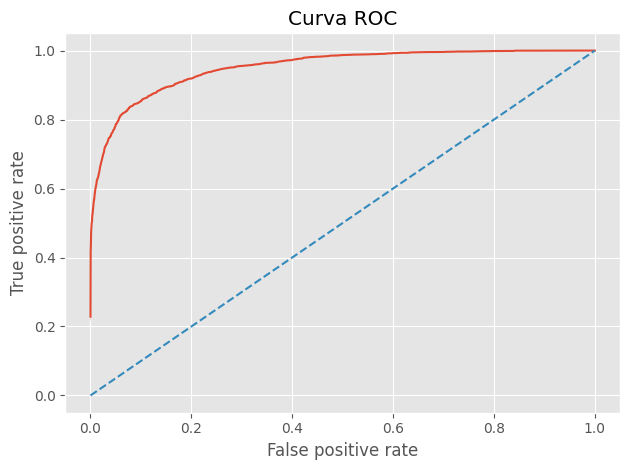

In [97]:
#CURVA ROC RF_GRIDSEARCH
Metrics.plot_roc_curve(y_test, y_prob)

In [98]:
#VALIDACION CRUZADA
from sklearn.model_selection import StratifiedKFold

#INSTANCIA DEL MODELO CON LOS PARAMETROS DE GRIDSEARCH
model = RandomForestClassifier( max_depth=20,
                                criterion='gini',
                                n_estimators=300,
                                min_samples_leaf=1,
                                min_samples_split=5,
                                bootstrap=False,
                                random_state=42)

#SE INSTANCIA MODELO DE VALIDACION CRUZADA
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#DIVICION DE DE DATOS PARA ITERACIONES
train_test = list(skf.split(x,y))

#LISTA PARA GUARDAR METRICAS
accuracies = []

#EJECUCION DE LA LOGICA DE MODELO
for k in range(skf.get_n_splits(x,y)):
    #Separacion de datos para train y test
    train, test = train_test[k]
    X_train, y_train, X_test, y_test = x.iloc[train], y.iloc[train], x.iloc[test], y.iloc[test]

    #Entrenamiento y prediccion
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #Guardado de resultados
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f'Accuracy iteracion {k+1}: {accuracy:.4f}')

#PROMEDIO DE ACCURACY CV
print(f'Accuracy promedio: {np.array(accuracies).mean():.4f}')

Accuracy iteracion 1: 0.8935
Accuracy iteracion 2: 0.8892
Accuracy iteracion 3: 0.8907
Accuracy iteracion 4: 0.8969
Accuracy iteracion 5: 0.8909
Accuracy promedio: 0.8922


En esta evaluacion de metricas, utilizando la validacion simple y la validacion cruzada con el metodo Stratified k-fold se pudo observar que los resultados varian de la siguiente manera:
- Precision de validacion simple = 0.8950
- Precision de validacion cruzafa = 0.8942
- Diferencia = 0.0008

Los resultados expresados muestran que el modelo es estable, ya que la metrica no varió demasiado en las diferentes validaciones. Tambien se entiende por estos resultados que el modelo no se sobreajusta, ya que si esto pasara las metricas deberian ser bastante diferentes.